## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.


# 1. Exploring data

Number of vehicle images found:  8792
Number of non-vehicle images found:  8968


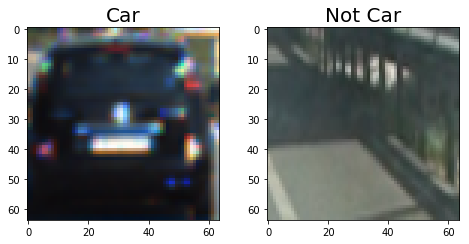

In [28]:
# read the training data and display some statistics
import os
import glob

# get the file names of vehicle images
basedir = '../p5/vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of vehicle images found: ', len(cars))

# get the file names of non-vehicle images
basedir = '../p5/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of non-vehicle images found: ', len(notcars))

# display a random car image and not car image
# Choose random car /not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Car', fontsize=20)
ax2.imshow(notcar_image)
ax2.set_title('Not Car', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [2]:
# imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque

# 2. Histogram of Oriented Gradients (HOG)

# 2.1 Fuctions defined in lesson
Below is a list of functions that are mostly straight copies of the functions defined in the course material

In [3]:
### Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
#     bin_edges = channel1_hist[1]
#     bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features
    
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9, hist_range=(0, 256),
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
            
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    hog_image = None
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


## 2.2 Visualize the HOG of a car image and a not car image

/Users/cure/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


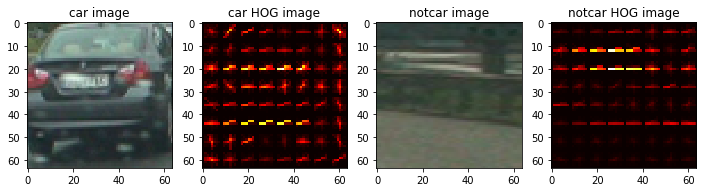

In [23]:
%matplotlib inline

# Choose random car /not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# define feature parameters
color_space = 'YCrCb' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2 or "ALL"
spatial_size = (32, 32)
hist_bins = 32 # number of histogram bins
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

# 2.3 Train the classifier

In [27]:
# Define feature parameters
color_space = 'YCrCb' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12 # 9 -> 0.991 # 12 -> 0.9904
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2 or 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, cspace=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=spatial_feat,
                               hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, cspace=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=spatial_feat,
                               hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to computer features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized traiing and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:', orient, 'orientations,', pix_per_cell, 'pixels per cell,', cell_per_block, 'cells per block,',
     hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))

# USe a linear SVC
svc = LinearSVC()

# Check the training time for SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/Users/cure/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


98.059730052948 Seconds to computer features...
Using: 12 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 10224
7.1 seconds to train SVC...
Test Accuracy of SVC =  0.9899


# 3. Sliding Window Search

## 3.1 Use the classifier and sliding window to search for cars in the test images

0.0 1.0


/Users/cure/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


9.107134103775024 seconds to process one image searching 57 windows
0.0 1.0
9.44535493850708 seconds to process one image searching 57 windows
0.0 1.0
9.779690980911255 seconds to process one image searching 57 windows
0.0 1.0
10.117110013961792 seconds to process one image searching 57 windows
0.0 1.0
10.46584415435791 seconds to process one image searching 57 windows
0.0 1.0
10.80475401878357 seconds to process one image searching 57 windows


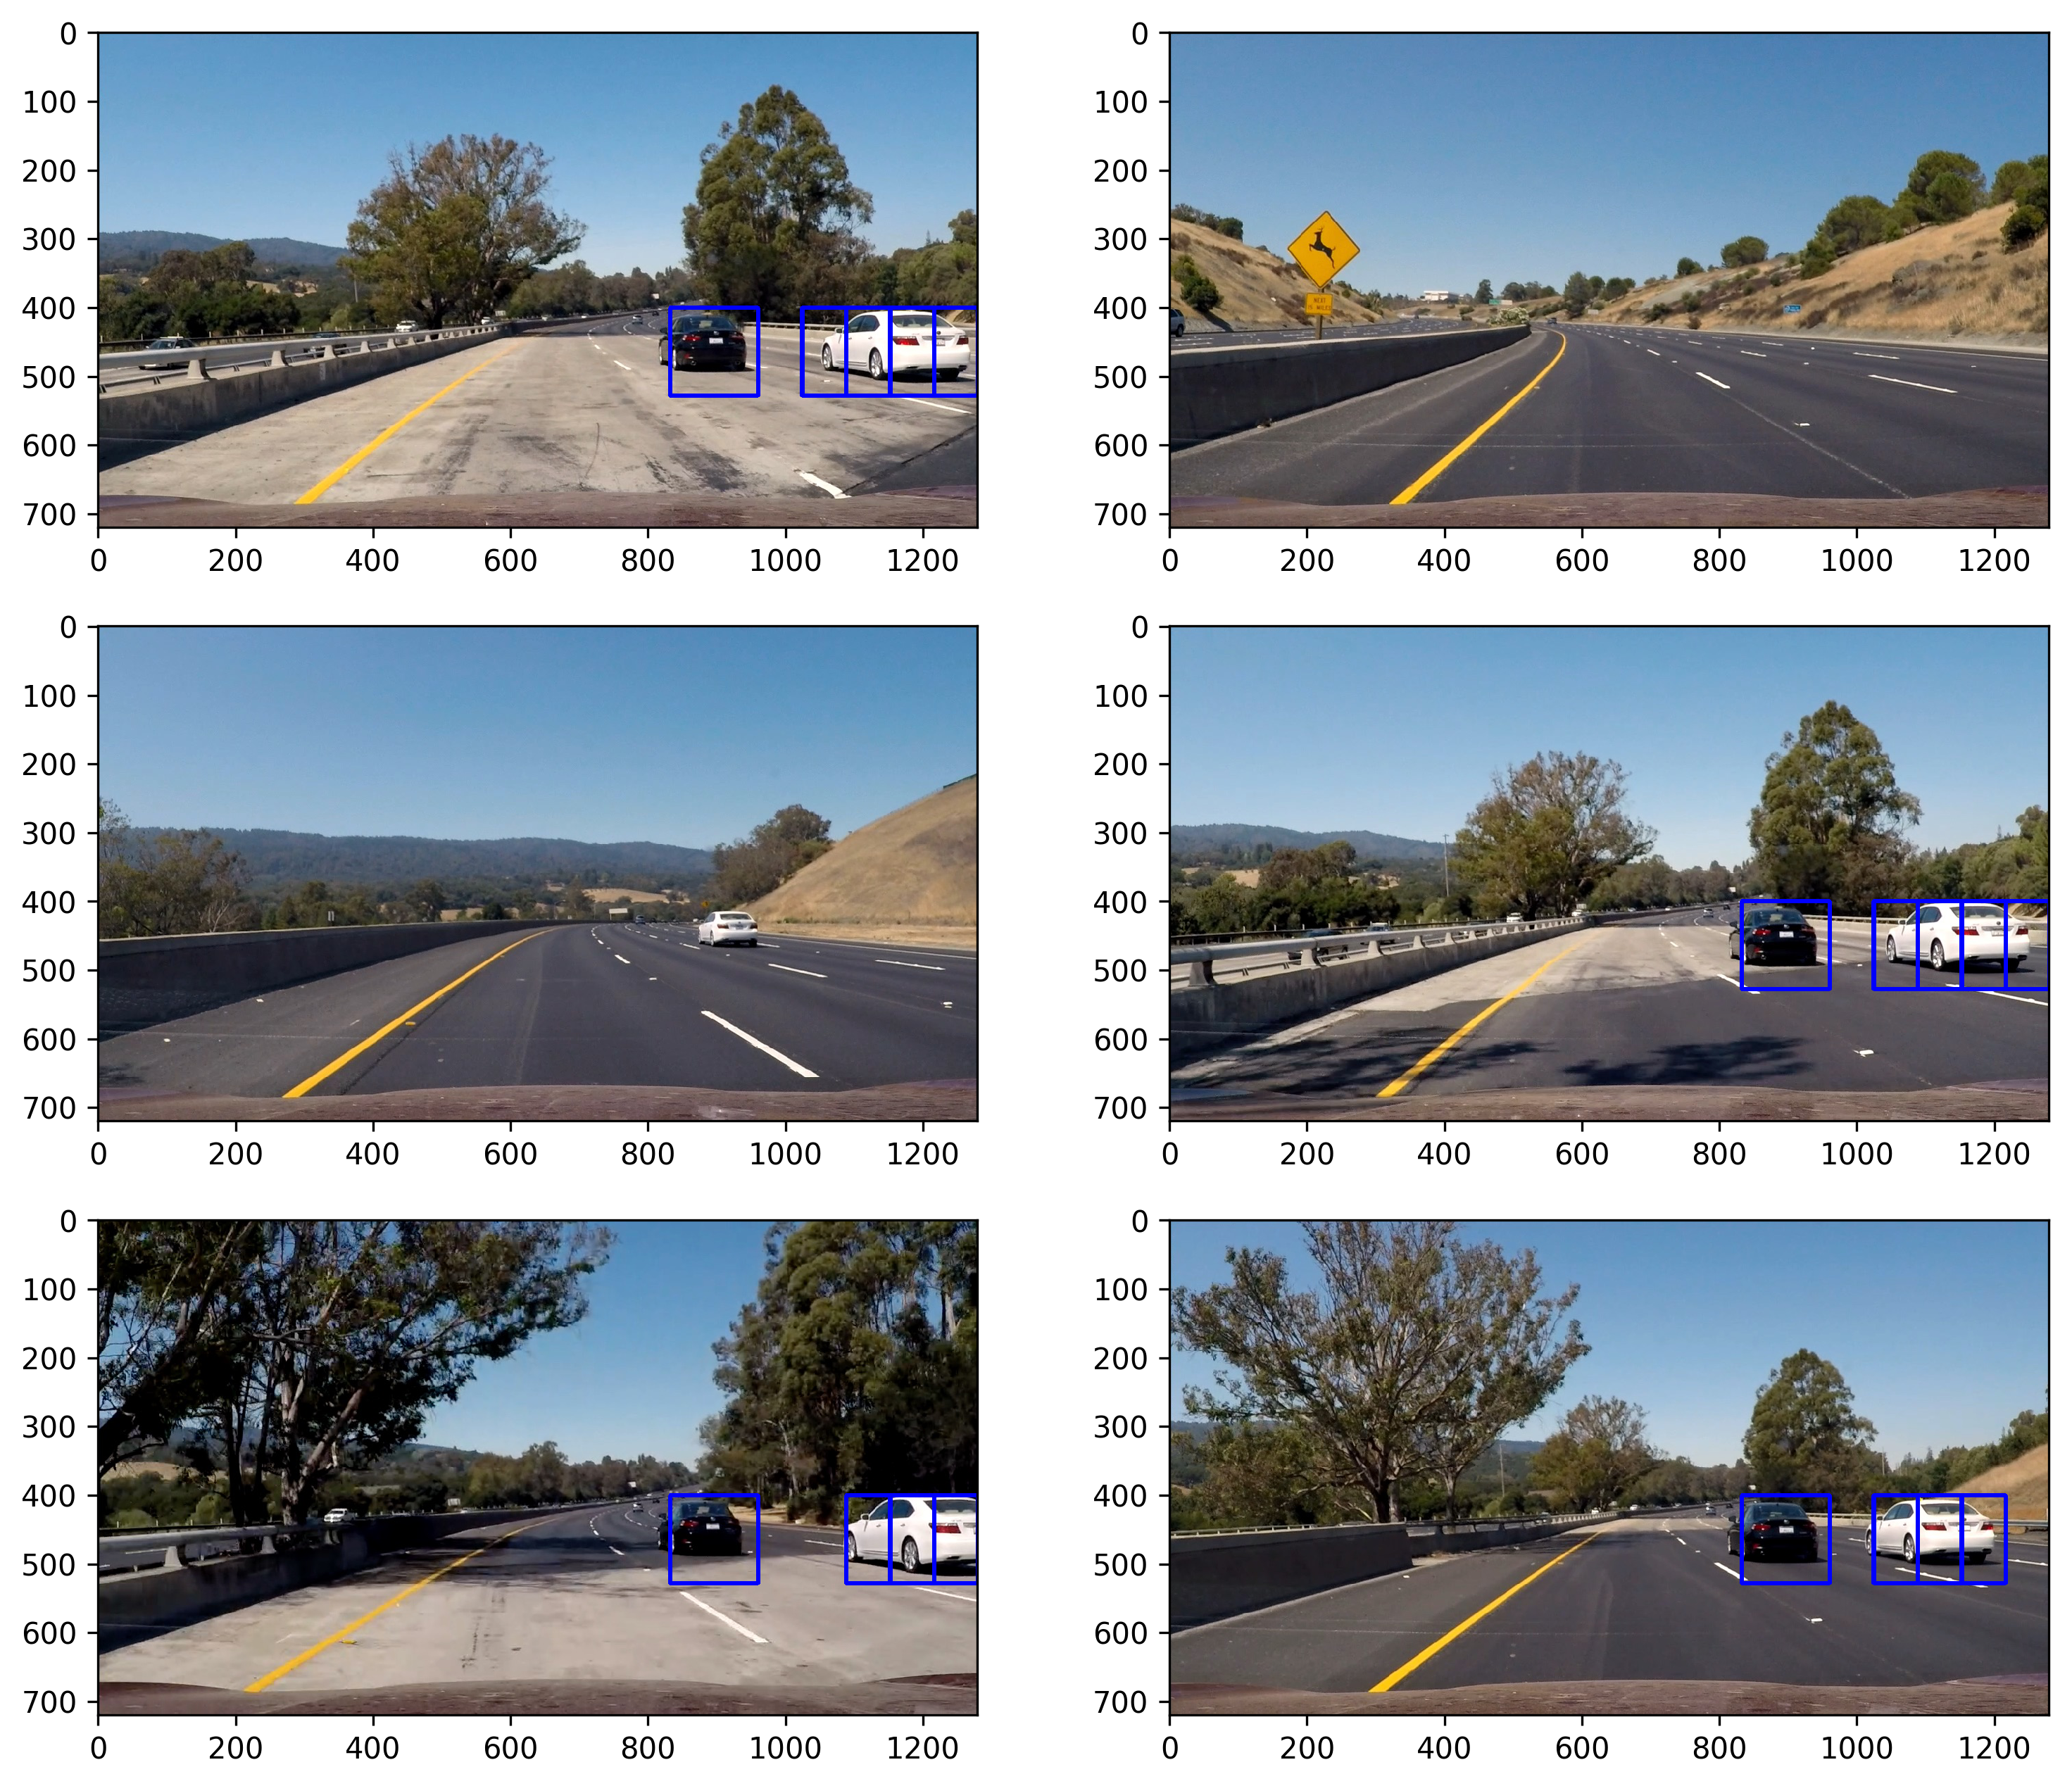

In [6]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # Min and Max in y to search in slide_window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(128,128), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t, 'seconds to process one image searching', len(windows), 'windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)


In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return ccv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## 3.2 Heatmap and threshold functions

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## 3.3 Define a single function that can extract features using hog sub-sampling and make predictions

In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # 0, 1, 2 or 'ALL'
    spatial_size = (32, 32)
    hist_bins = 32

    img_boxes = []
    t = time.time()
    count = 0

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, img_boxes, heatmap, count

## 3.4 Try the pipeline on test images

In [10]:
out_images = []
out_maps = []
out_titles = []

ystart = 400
ystop = 656
scale = 1

# iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    
    out_img, bboxes, heatmap, count = find_cars(img, ystart, ystop, scale, svc, X_scaler)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    # draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_images.append(heatmap)
    out_titles.append(img_src[-9:])
    out_maps.append(heatmap)
    
fig = plt.figure(figsize=(12,28), dpi=300)
visualize(fig, 8, 2, out_images, out_titles)

/Users/cure/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,8460) (10224,) (1,8460) 

# 4. Video Implementation

I tried search at different scales. But it doesn't seem to give me noticible improvements so I chose to leave it out and search at 1.5 scale only.

In [ ]:
ystart = 400
ystop = 656

heatmaps = deque(maxlen=10)

def process_image(img):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # search at origin scale first
#     ystart = 350
#     ystop = 500
#     scale = 1
#     out_img, bboxes, heatmap, count = find_cars(img, ystart, ystop, scale, svc, X_scaler)
#     current_heatmap = add_heat(heat, bboxes)

    ystart = 368
    ystop = 656
    scale = 1.5 # search at origin scale first
    out_img, bboxes, heatmap, count = find_cars(img, ystart, ystop, scale, svc, X_scaler)
    current_heatmap = add_heat(heat, bboxes)
    
#     ystart = 400
#     ystop = 656
#     scale = 2 # search at origin scale first
#     out_img, bboxes, heatmap, count = find_cars(img, ystart, ystop, scale, svc, X_scaler)
#     current_heatmap = add_heat(heat, bboxes)
    
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)
    heatmap = apply_threshold(heatmap_sum, 8)
    labels = label(heatmap)
    # draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_file = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip = VideoFileClip("project_video.mp4").subclip(25,50)
clip = VideoFileClip("project_video.mp4")
write_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time write_clip.write_videofile(output_file, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

NameError: name 'HTML' is not defined

** NOTE: This is not used. **

In [ ]:
# Define a class to receive the characteristics of each vehicle detection
# Objects defined as "Vehicles" will be where multiple overlapping detections exist in the heatmap
class Vehicle():
    def __init__(self):
        sefl.detected = False # was the Vehicle detected in the last iteration
        self.n_detections = 0 # Number of times this vehicle has been detected
        self.n_nondetections = 0 # Number of consecutive times this car has not been detected since detection
        self.xpixels = None # Pixel x values of last detection
        self.ypixels = None # Pixel y values of last detection
        self.recent_xfitted = [] # x position of the last n fits of the bounding box
        self.bestx = None # average x position of the last n fits
        self.recent_yfitted = [] # y position of the last n fits of the bounding box
        self.besty = None # average y position of the last n fits
        self.recent_wfitted = [] # width of the last n fits of the bounding box
        self.bestw = None # average width of the last n fits
        self.recent_hfitted = [] # height of the last n fits of the bounding box
        self.besth = None # average height of the last n fits
        